In [ ]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,945 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import os

In [1]:
df = pd.read_csv('/content/drive/MyDrive/ExtractKU/DE-TRAIN.csv')

NameError: ignored

In [ ]:
!pip install pdf2image
!apt-get install poppler-utils

In [ ]:
import os
from pdf2image import convert_from_path

BASE_PDF_DIR = '/content/drive/MyDrive/ExtractKU/Train Files'
BASE_IMG_DIR = '/content/drive/MyDrive/ExtractKU/Train Images'
pdfs = os.listdir("/content/drive/MyDrive/ExtractKU/Train Files")

for pdf in pdfs:
  print(f'{BASE_PDF_DIR}/{pdf}')
  images = convert_from_path(f'{BASE_PDF_DIR}/{pdf}')

  for i in range(len(images)):
      images[i].save(BASE_IMG_DIR + '/' + pdf.rsplit('.')[0] +'.jpg', 'JPEG')

In [ ]:
!pip install opencv-python

In [ ]:
import numpy as np

import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

path = "/content/drive/MyDrive/ExtractKU"
BASE_IMG_DIR = path + '/Train Images'


def mask_two(image_name):
  # Define the dimensions of the center rectangle
  image_path = path +"/Train Images/" +image_name
  image = cv2.imread(image_path)

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # Define the coordinates of the rectangle to be masked
  x, y, width, height = 100, 50, 200, 150

  # Create a mask of the same size as the image
  mask = np.zeros_like(gray_image)
  x, y, width, height = 30, 300, 1200, 70

  # Draw a filled white rectangle on the mask
  cv2.rectangle(mask, (x, y), (x + width, y + height), (255, 255, 255), thickness=cv2.FILLED)


  x, y, width, height = 1330, 1000, 300, 1000

  # Draw a filled white rectangle on the mask
  cv2.rectangle(mask, (x, y), (x + width, y + height), (255, 255, 255), thickness=cv2.FILLED)
  # Bitwise AND operation to apply the mask to the image
  masked_img = cv2.bitwise_and(gray_image, mask)
  cv2.imwrite(path + "/Masked Images/" + image_name, masked_img)

images = os.listdir(BASE_IMG_DIR)

for image in images:
  mask_two(image)

In [ ]:
labels = list(df['label'].unique())
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

In [ ]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

In [ ]:
datas = []
filenames = os.listdir('/content/drive/MyDrive/ExtractKU/Masked Images')
for filename, i in zip(filenames, range(len(filenames))):
  d = {}
  d['id'] = i
  d['words'] = []
  d['bboxes'] = []
  d['ner_tags'] = []
  d['image_path'] = f'/content/drive/MyDrive/ExtractKU/Masked Images/{filename}'
  items = df[df['file_name'] == f'{filename.split(".")[0]}.pdf']
  for j in range(len(items)):
    item = items.iloc[j]
    d['words'].append(item['value'])
    d['bboxes'].append(normalize_bbox([item['x0'], item['y0'], item['x2'], item['y2']], 1700, 2200))
    d['ner_tags'].append(label2id[item['label']])
  datas.append(d)

In [ ]:
num_train = 140
data_train = Dataset.from_list(datas[:num_train])
data_valid = Dataset.from_list(datas[num_train:])

In [ ]:
dataset = DatasetDict({"train":data_train, "test": data_valid})

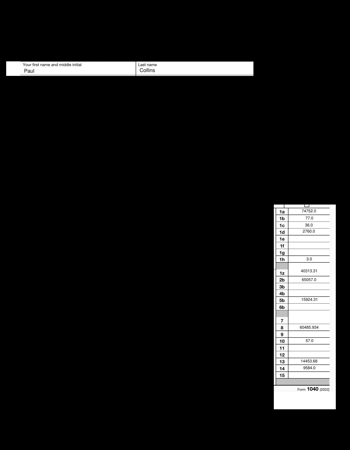

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

In [ ]:
from transformers import LayoutLMv2Processor
processor_id="microsoft/layoutlmv2-large-uncased"
# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

preprocessor_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/862 [00:00<?, ?B/s]

In [ ]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [ ]:
from transformers import LayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlmv2-large-uncased"

# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

You are using a model of type layoutlmv2 to instantiate a model of type layoutlm. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-large-uncased and are newly initialized: ['layoutlm.encoder.layer.0.output.dense.weight', 'layoutlm.encoder.layer.10.attention.self.value.weight', 'layoutlm.encoder.layer.11.attention.self.key.bias', 'layoutlm.encoder.layer.10.attention.output.LayerNorm.bias', 'layoutlm.encoder.layer.2.output.LayerNorm.bias', 'layoutlm.encoder.layer.11.intermediate.dense.weight', 'layoutlm.encoder.layer.17.attention.output.dense.weight', 'layoutlm.encoder.layer.12.attention.self.key.weight', 'layoutlm.encoder.layer.4.output.dense.bias', 'layoutlm.encoder.layer.9.output.LayerNorm.weight', 'layoutlm.encoder.layer.9.attention.self.value.weight', 'layoutlm.encoder.layer.21.intermediate.dense.weight', 'layoutlm.encoder.layer.13.attention.self.value.weight', 'layoutlm.encoder.layer.13.attention.self.query.weight', 'layoutlm.encoder.layer.19.attention.self.query.bias', 'layoutlm.encoder.layer.

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])


In [ ]:
#Uncomment, Run, Restart Session, Comment the following lines
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "kuitm"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=8,
    fp16=False,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:196: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


events.out.tfevents.1701514133.4312dd3a81e2.2530.0:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

'https://huggingface.co/pratikstha/layoutlm-funsd/tree/main/'

1


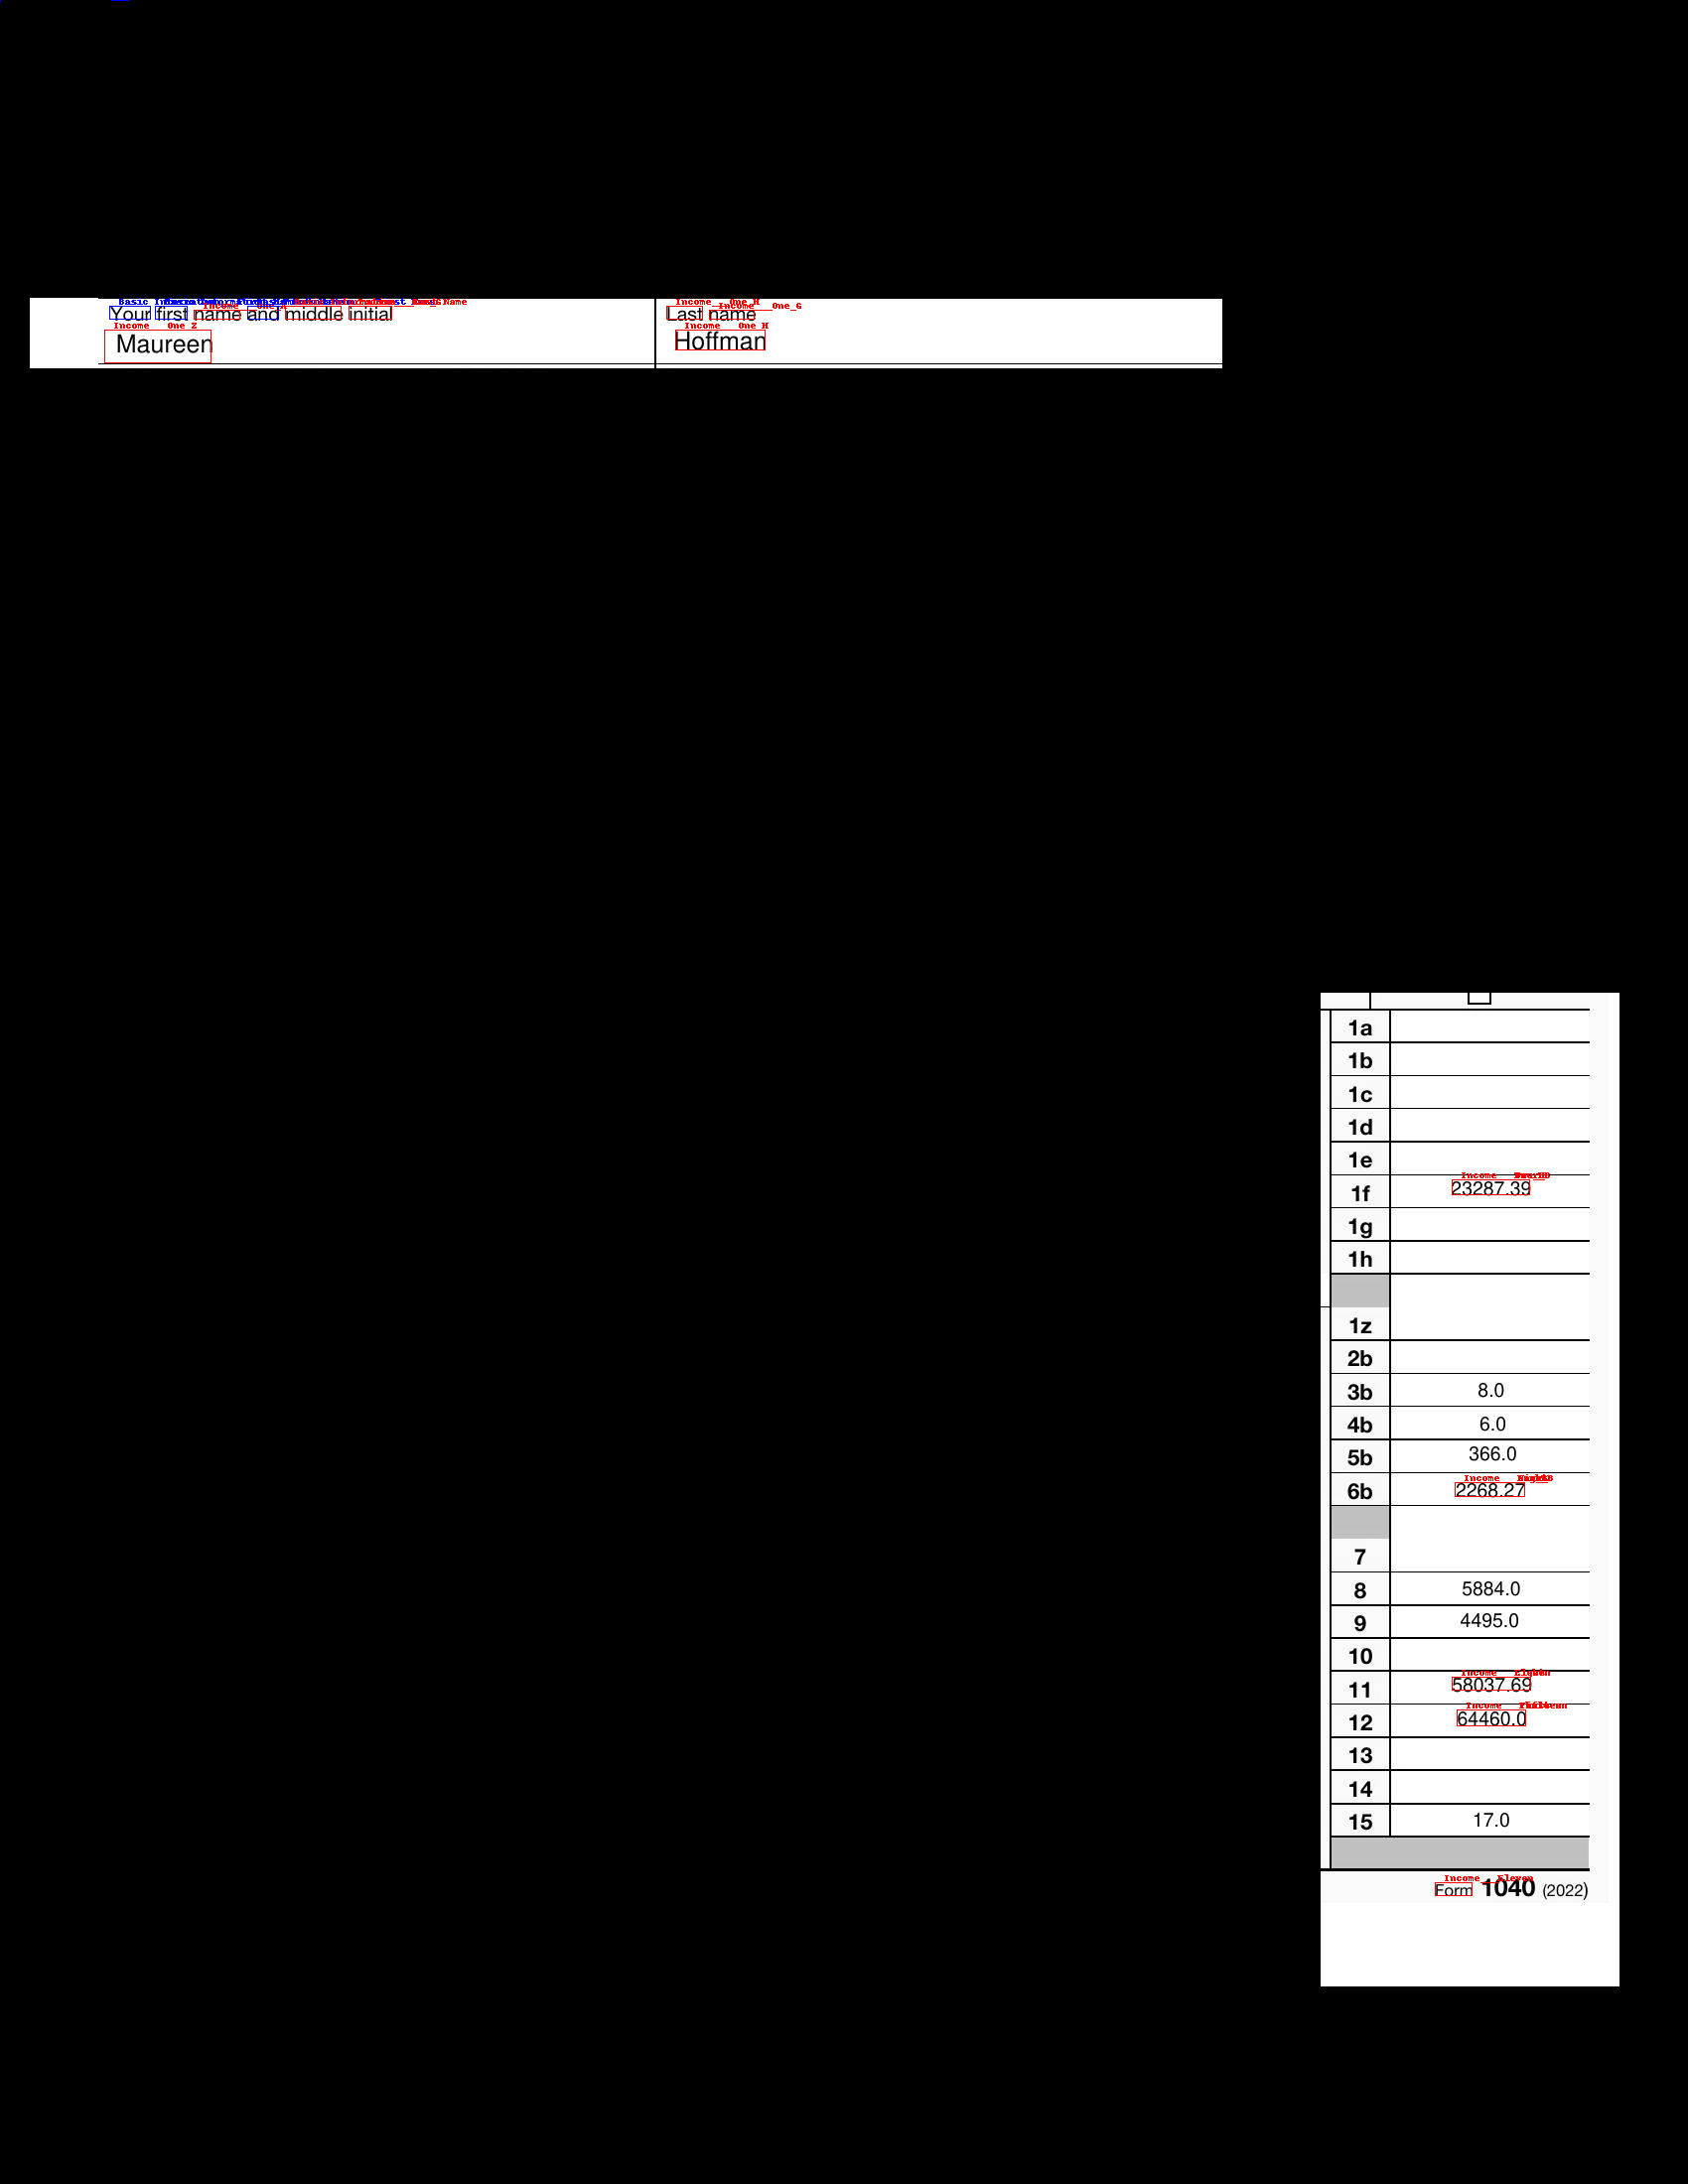

In [ ]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LayoutLMForTokenClassification.from_pretrained("pratikstha/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("pratikstha/layoutlm-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

label2color = {'Basic Information___First Name': "blue",
 'Basic Information___Last Name': "red",
 'Income___One_F': "green",
 'Income___Three_B': "blue",
 'Income___Four_B': "red",
 'Income___Five_B': "red",
 'Income___Six_B': "red",
 'Income___Eight': "red",
 'Income___Nine': "red",
 'Income___Eleven': "red",
 'Income___Twelve': "red",
 'Income___Fifteen': "red",
 'Income___One_A': "red",
 'Income___One_C': "red",
 'Income___One_E': "red",
 'Income___One_G': "red",
 'Income___Seven': "red",
 'Income___One_H': "red",
 'Income___Ten': "red",
 'Income___Thirteen': "red",
 'Income___Two_B': "red",
 'Income___Fourteen': "red",
 'Income___One_D': "red",
 'Income___One_Z': "red",
 'Income___One_B': "red"
 }


# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
encoding = None
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    print(len(encoding['input_ids']))
    del encoding["image"]
    # run inference
    outputs = model(**encoding)
    p = torch.nn.functional.softmax(outputs.logits[0], dim=-1)
    predictions = [pred.argmax(-1) for pred in p if pred.max(-1).values.item() > 0.1]
    # predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction.item()] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference("/content/drive/MyDrive/aayo.png")
